## Importing the necessary libraries ##

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Choosing the stock ##
I'm choosing AAPL as it is a large market cap tech stock which has limited intrinsic volatility. Since the S&P 500 is largely comprised of tech stocks, my hope is that a successful strategy on AAPL should translate to other large-cap tech stocks in the S&P 500. I'm also choosing a 5-year horizon for the analysis as it is sufficiently long with multiple bear and bull financial years.

In [2]:
stock = 'AAPL'
horizon = '5y'

data = yf.Ticker(stock)
ohlcv = data.history(period=horizon)

ohlcv

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-22 00:00:00-05:00,132.662066,136.137298,131.435522,135.378006,114459400,0.0,0.0
2021-01-25 00:00:00-05:00,139.271835,141.238199,132.915178,139.125809,157611700,0.0,0.0
2021-01-26 00:00:00-05:00,139.787742,140.469156,137.616933,139.359421,98390600,0.0,0.0
2021-01-27 00:00:00-05:00,139.622276,140.469189,136.682460,138.288651,140843800,0.0,0.0
2021-01-28 00:00:00-05:00,135.816074,138.220502,133.070931,133.450577,142621100,0.0,0.0
...,...,...,...,...,...,...,...
2026-01-15 00:00:00-05:00,260.649994,261.040009,257.049988,258.209991,39388600,0.0,0.0
2026-01-16 00:00:00-05:00,257.899994,258.899994,254.929993,255.529999,72142800,0.0,0.0
2026-01-20 00:00:00-05:00,252.729996,254.789993,243.419998,246.699997,80267500,0.0,0.0


## Basic Data Cleaning ##
I want to make sure that there are no stock splits. Stock splits massively change the price, but the price x volume always remains constant. If there is a stock split, I would've normalized the data. However, AAPL has had no stock splits for the past 5 years. I also looked into when AAPL pays out dividends for their stockholders. Paying out dividends leads to an "Adjusted Close Price". For the sake of this notebook, I will ignore the "Adjusted Close Price" and work with only the actual "Close Price". 

In [3]:
stock_split = ohlcv[ohlcv['Stock Splits'] != 0]            #Empty dataframe -> no stock splits
dividends = ohlcv[ohlcv['Dividends'] != 0]                 #Non-empty dataframe -> Dividends paid out on Feb, May, Aug, Nov (once per quarter)

## Terms explained ##
Any strategy must perform better than a baseline 'Buy-and-Hold' strategy. If it does not, then there is no reason to trade. 

* A ***trading strategy*** should output a 'signal'.
* An ***execution strategy*** should output a 'position'.
* A ***backtest*** should retroactively test the position derived from the strategy against a baseline using historical data.

### Signal ###
A 'signal' is an action to be taken in the present (Buy, hold or sell). This is stateless and does not need information about the previous states. In this notebook, (buy, hold, sell) is encoded as (+1, 0, -1). This should be the output of any trading strategy function.

### Postion ###
A 'position' is a portfolio derived based on the signal. A position's state needs to be remembered across time, and any new signal should modify the existing position. In this notebook (long, flat, short) is encoded as (+1, 0, -1). This should be the output of any execution strategy.

### Backtest ###
A 'backtest' is an evaluation method applying the strategy on a historical dataset and comparing it against the baseline 'buy-and-hold'. It provides a retrospective metric of how 'good' a strategy performs. Log-returns are used as a metric as they are symmetric and additive in nature. This notebook only measures the log returns metric. However, future scope is planned to measure risk from drawdowns, exposure, volatality and number of trades (as transaction costs may chip away at returns).


In this notebook, the backtest function alone provides the functionalities of the signal and execution functions. In later iterations, this would be separated. 

In [4]:
def backtest(data, fast_window, slow_window):
    df = data.copy()
    
    #Computing the slow and fast simple moving indicators
    df['slow'] = df['Close'].rolling(slow_window).mean()
    
    #In case the price is the fast indicator
    if fast_window == 0:
        df['fast'] = df['Close']
    else:
        df['fast'] = df['Close'].rolling(fast_window).mean()    

    #In line with standard, I'm using +1 for buy and -1 for sell
    df['signal'] = 0

    #Buy when fast-sma goes above slow-sma
    df.loc[(df['fast'] >= df['slow']) & (df['fast'].shift(1) < df['slow'].shift(1)), 'signal'] = 1

    #Sell when fast-sma goes below slow-sma
    df.loc[(df['fast'] <= df['slow']) & (df['fast'].shift(1) > df['slow'].shift(1)), 'signal'] = -1

    #Buy when signal is 1, sell when signal is -1
    #Position can only be 1 (exposed to market) or 0 (flat cash). It cannot be -1 as I am not planning on shorting the stock with this strategy
    df['position'] = pd.NA
    df.loc[df['signal'] == 1, 'position'] = 1
    df.loc[df['signal'] == -1, 'position'] = 0
    df['position'] = df['position'].ffill().fillna(0)                         #Holding between signals, flat-cash otherwise

    #Calculating log-returns
    df['market_return_per_day'] = np.log(df['Close']/df['Close'].shift(1))

    #Buy and hold strategy is the baseline that this strategy is trying to beat
    df['bh_return'] = df['market_return_per_day'].cumsum()

    #Strategy's returns
    df['strategy_return_per_day'] = df['market_return_per_day'] * df['position'].shift(1)  #We get returns only after we are exposed to the market, shift(1) ensures that
    df['strategy_return'] = df['strategy_return_per_day'].cumsum()


    #Plotting the graphs for visualization
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(12,8), sharex=True)    #sharex aligns time axis in both the graphs for better readability

    #Plotting price and moving averages    
    axes[0].plot(df.index, df['Close'])
    axes[0].plot(df.index, df['slow'], label='slow_indicator')
    if fast_window != 0:
        axes[0].plot(df.index, df['fast'], label='fast_indicator')
    axes[0].set_ylabel('Price')
    axes[0].set_title('Price and indicator(s)')
    axes[0].legend()
    axes[0].grid(True)

    #Plotting baseline and strategy returns
    axes[1].plot(df.index, df['bh_return'], label='Buy & Hold')
    axes[1].plot(df.index, df['strategy_return'], label='Strategy')
    axes[1].set_ylabel('Cumulative Log Return')
    axes[1].set_title('Returns')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()    
    plt.show()

    #Returing the metrics
    return df['bh_return'].iloc[-1], df['strategy_return'].iloc[-1]

Since I am not performing intra-day trading in this notebook, I will just choose the 'Close' prices as my target price variable. The other indicators that I want to look at are 10-day, 50-day, and 200-day simple moving averages. Their interactions with the price will form the basis of my strategies.

C:\Users\aakas\AppData\Local\Temp\ipykernel_6852\454420267.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['position'] = df['position'].ffill().fillna(0)                         #Holding between signals, flat-cash otherwise


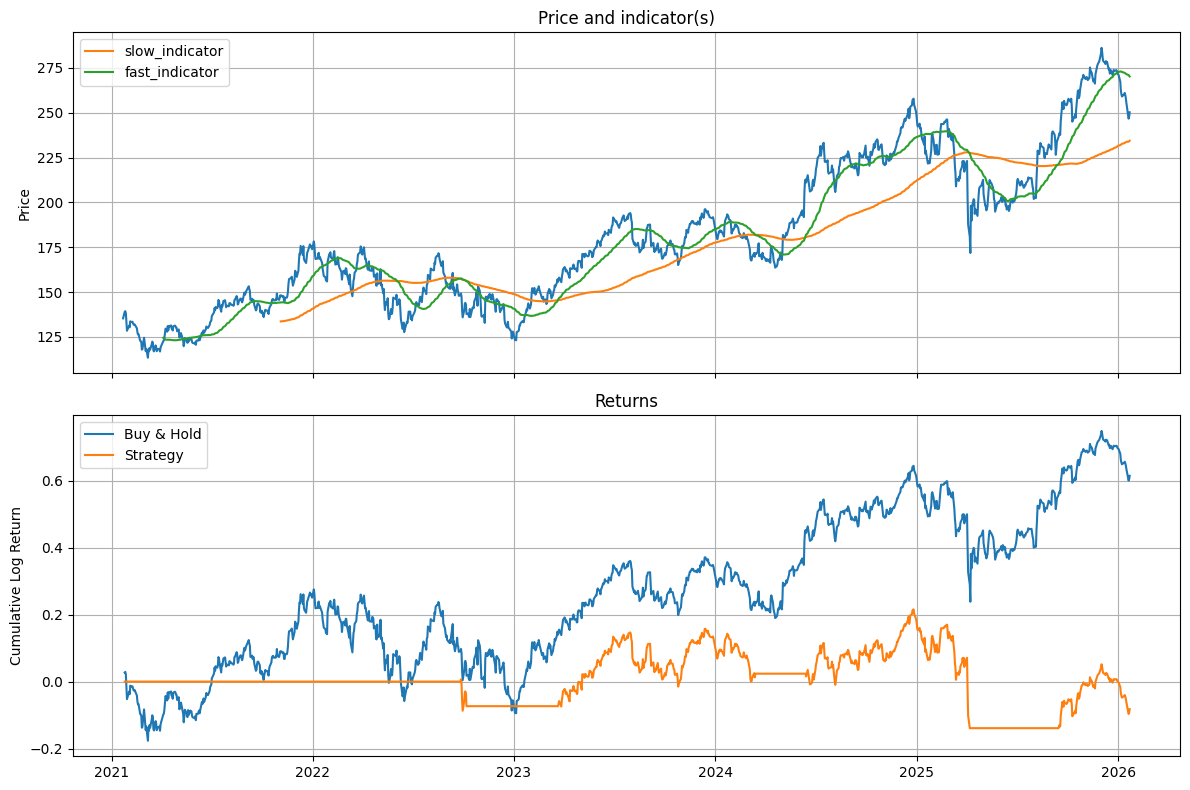

In [5]:
close = ohlcv[['Close']].copy()

# Strategy 1: 50-SMA and 200-SMA crossover
baseline_50_200, strategy_50_200 = backtest(close, 50, 200)

C:\Users\aakas\AppData\Local\Temp\ipykernel_6852\454420267.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['position'] = df['position'].ffill().fillna(0)                         #Holding between signals, flat-cash otherwise


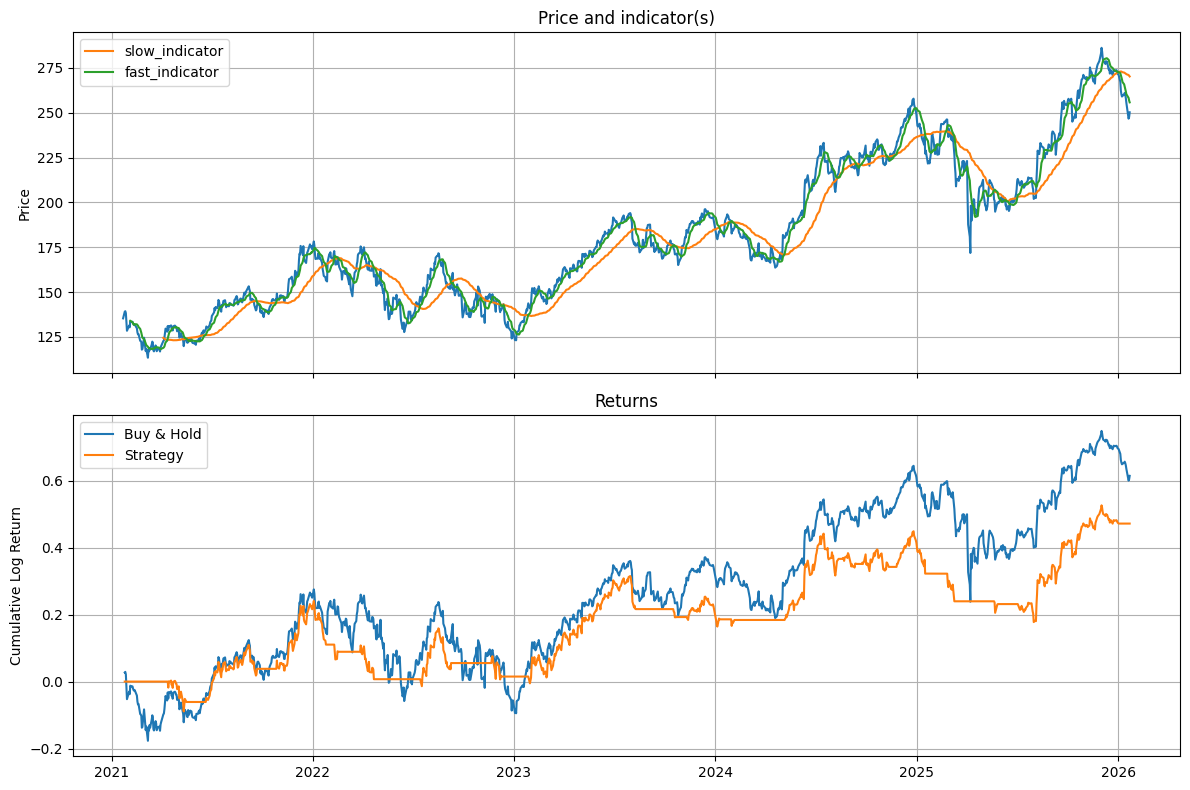

In [6]:
# Strategy 2: 10-SMA and 50-SMA crossover
baseline_10_50, strategy_10_50 = backtest(close, 10, 50)

C:\Users\aakas\AppData\Local\Temp\ipykernel_6852\454420267.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['position'] = df['position'].ffill().fillna(0)                         #Holding between signals, flat-cash otherwise


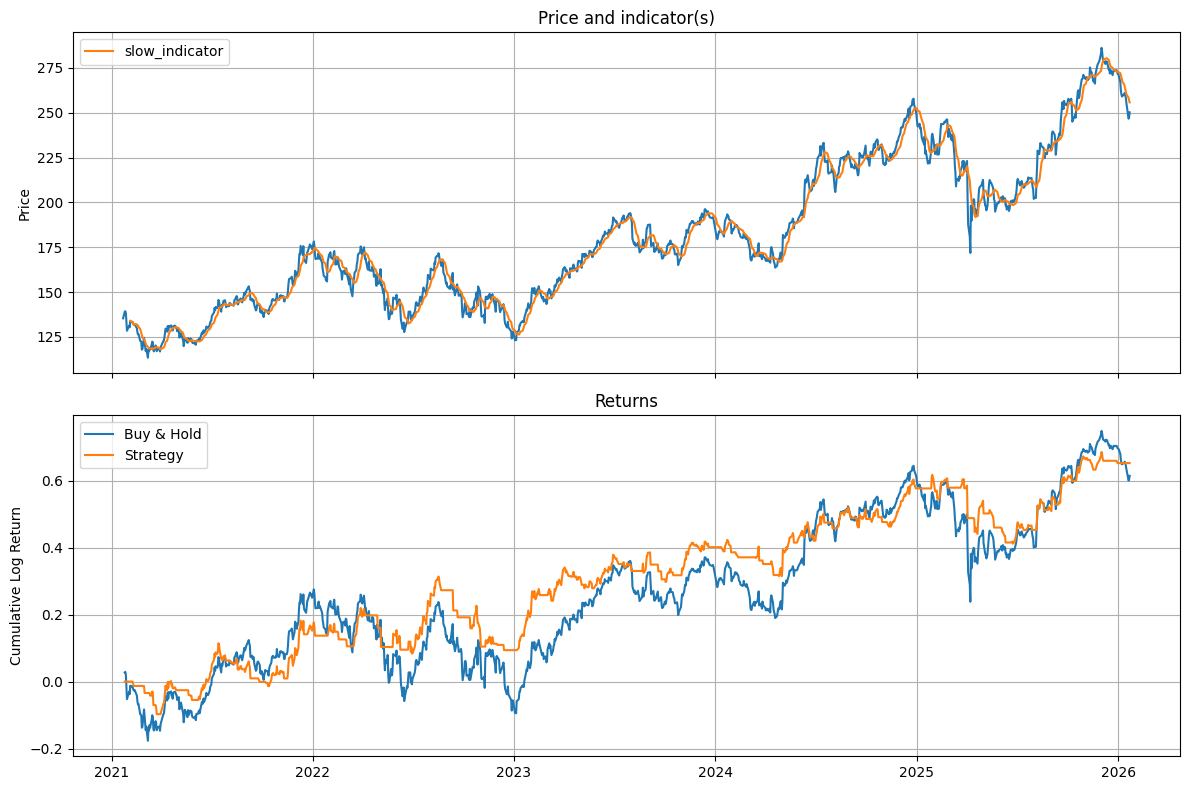

In [7]:
# Strategy 3: price and 10-SMA crossover
baseline_0_10, strategy_0_10 = backtest(close, 0, 10)

In [8]:
#Collating all the results
results = pd.DataFrame({
    'Strategy' : ['50-SMA and 200-SMA crossover', '10-SMA and 50-SMA crossover', 'price and 10-SMA crossover'],
    'Baseline returns': [baseline_50_200, baseline_10_50, baseline_0_10],
    'Strategy returns': [strategy_50_200, strategy_10_50, strategy_0_10]})

results

,Strategy,Baseline returns,Strategy returns
0,50-SMA and 200-SMA crossover,0.61439,-0.082444
1,10-SMA and 50-SMA crossover,0.61439,0.471826
2,price and 10-SMA crossover,0.61439,0.652427


The following observations can be made:

* 50-sma and 200-sma would lose money over time as the returns are negative. This is not a good strategy as 200-sma is too slow to react to uptrends and drawdowns leading to a greater exposure to volatality.
* 10-sma and 50-sma provide better returns than the previous strategy but it still lags behind the baseline as it fails to capture a significant uptrend and the errors will only propogate across time.
* 10-sma and price was the only model that outperforms the baseline. However, there are a lot more transactions which may lead to a higher transaction cost. Moreover, caution must be exercised as this strategy is only slightly lesser exposed to risk than the baseline.